In [76]:
import pandas as pd
import chordparser
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

---------------

### Definitions

In [77]:
cp = chordparser.Parser()
CE = chordparser.ChordEditor()
CRC = chordparser.ChordRomanConverter()

In [78]:
sharps_to_flats = {
    'C#': 'Db',
    'D#': 'Eb',
    'F#': 'Gb',
    'G#': 'Ab',
    'A#': 'Bb',
}

In [79]:
lower_base = {
    'C': 'B',
    'B': 'Bb',
    'Bb': 'A',
    'A': 'Ab',
    'Ab': 'G',
    'G': 'Gb',
    'Gb': 'F',
    'F': 'E',
    'E': 'Eb',
    'Eb': 'D',
    'D': 'Db',
    'Db': 'C'
}

In [80]:
number_of_songs = {'Country': 0,
                   'Electronic': 0,
                   'Pop': 0,
                   'Rock': 0}

In [81]:
# {'Country': ['major', 'minor', 'minor', ...], 'Pop': ...}
modes = {'Country': [],
        'Electronic': [],
        'Pop': [],
        'Rock': []}

In [82]:
# {'Country': {'IV': 30, 'V': 2, ...}, 'Pop': {...}, ...}
nodelists_sum = {'Country': {},
                 'Electronic': {},
                 'Pop': {},
                 'Rock': {}}

In [83]:
dataframes = {'Country': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Electronic': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Pop': pd.DataFrame(columns=['from_roman', 'to_roman']),
              'Rock': pd.DataFrame(columns=['from_roman', 'to_roman'])}

In [84]:
nodelists = {}

----------------------

### Single song processing

In [85]:
def get_roman_dataframe(file):
    # dataframe
    df = pd.read_csv(file, delimiter='\t', skiprows=2, header=None)
    df.columns=['from', 'to']

    # signature
    with open(file, "r") as fin:
        signature = fin.readlines()[:2]
        
    base = re.split(':|\\n', signature[0])[1]
    capo = re.split(':|\\n', signature[1])[1]
    
    if capo == 'None':
        capo = 0
    else:
        capo = int(capo)

    # key and scale
    if('m' in base):
        mode = 'minor'
        base = base.replace('m', '')
    else:
        mode = 'major'
        
    if base in sharps_to_flats.keys() and base != df['from'][0].replace('m', ''):
        base = sharps_to_flats[base]  

    for i in range(capo):
        base = lower_base[base]

    key = cp.create_key(base, mode)

    df['from'] = df['from'].apply(lambda x: x.replace(')', '').replace('(', '').replace('-5', 'b5').replace('+5', '#5').replace('-', ''))#.replace('5', '').replace('-', ''))
    df['to'] = df['to'].apply(lambda x: x.replace(')', '').replace('(', '').replace('-5', 'b5').replace('+5', '#5').replace('-', ''))#.replace('5', '').replace('-', ''))

    # add mode to dict
    genre = file.split('/')[2]
    modes[genre].append(mode)

    # convert to roman
    if base in sharps_to_flats.keys():
        base = sharps_to_flats[base]  
        
    df['from_roman'] = df['from'].apply(lambda x: str(CRC.to_roman(CE.create_chord(x),key)))
    df['to_roman'] = df['to'].apply(lambda x: str(CRC.to_roman(CE.create_chord(x),key)))
    
    df = df.drop(columns=['from','to'])

    return df

In [86]:
def add_to_nodelist(df, genre):    
    all_chords = pd.unique(df.values.ravel('K'))
        
    for chord in all_chords:
        value_count = 0
        
        if chord in df.from_roman.values:
            value_count = df.from_roman.value_counts()[chord]

        # include last chord
        if (df.to_roman.iloc[-1]) == chord:
            value_count += 1

        # add appearances to nodelist
        if chord not in nodelists_sum[genre].keys():
            nodelists_sum[genre][chord] = 0
        nodelists_sum[genre][chord] += value_count

    return

In [87]:
def process_song(file):

    df = get_roman_dataframe(file)
    
    genre = file.split('/')[2]
    
    dataframes[genre] = dataframes[genre].append(df)
    add_to_nodelist(df, genre)

    number_of_songs[genre] += 1

### Genre processing

In [88]:
def create_nodelist(genre):
    df = pd.DataFrame([nodelists_sum[genre]])
    df = df.T.rename(columns={0: 'sum_appearance'})
    
    df['percent'] = df['sum_appearance'] / df['sum_appearance'].sum()
    df['average_appearance'] = df['sum_appearance'] / number_of_songs[genre]

    df = df.reset_index()
    df = df.rename(columns={'index': 'Id'})
    
    return df

In [89]:
def get_percentages(df, nodelist):

    df = df.groupby(df.columns.tolist(),as_index=False).size()
    df['percent'] = df['size'] / df['size'].sum()
    
    df = df.rename(columns={'size': 'sum_appearance', 'from_roman': 'Source', 'to_roman': 'Target'})

    log_ratio = []
    for i, row in df.iterrows():
        source_percent = nodelist.loc[nodelist['Id'] == row.Source, 'percent'].iloc[0]
        target_percent = nodelist.loc[nodelist['Id'] == row.Target, 'percent'].iloc[0]
        log_ratio.append(np.log(row.percent / (source_percent * target_percent)))

    df['log_ratio'] = log_ratio

    return df

In [90]:
def get_probabilities(df):
    
    probs = []
    for i, row in df.iterrows():
        from_chord_df = df[df['Source'] == row.Source]
        probs.append(row['sum_appearance'] / from_chord_df['sum_appearance'].sum())

    df['probability'] = probs
    
    return df

--------------

## Main

### Process every song

In [91]:
directory = '../data/'

for subdir, dirs, files in os.walk(directory):
    for i, filename in enumerate(os.listdir(subdir)):
        f = os.path.join(subdir, filename)
        if os.path.isfile(f):
            df = process_song(f)

### Process genres and save intermittent dataframes

In [92]:
for genre, df in dataframes.items():
    nodelists[genre] = create_nodelist(genre)
    
    dataframes[genre].to_csv('../results/dataframes/df_' + genre.lower() + '.csv')

    dataframes[genre] = get_percentages(df, nodelists[genre])
    dataframes[genre] = get_probabilities(dataframes[genre])

### Log-Ratio

In [93]:
dataframes['Pop'][dataframes['Pop']['percent']>0.003].sort_values('probability', ascending=False)

,Source,Target,sum_appearance,percent,log_ratio,probability
35,I6,IV,47,0.004969,1.884760,0.723077
385,vii,V,78,0.008247,1.695970,0.639344
448,♭VII,i,30,0.003172,1.865677,0.491803
78,III,VII,217,0.022944,1.739023,0.442857
377,vi7,IV,29,0.003066,1.386640,0.439394
...,...,...,...,...,...,...
125,IV,ii,36,0.003806,0.129558,0.034286
163,V,iii,38,0.004018,0.533844,0.033838
162,V,ii,34,0.003595,0.006682,0.030276
2,I,I6,37,0.003912,1.460069,0.029600


### Co-occurence Matrix

In [94]:
coocc = {}

In [95]:
import networkx

for genre, df in dataframes.items():
    edgeList = df[['Source', 'Target', 'percent']].values.tolist()
    G = networkx.DiGraph()
    for i in range(len(edgeList)):
        G.add_edge(edgeList[i][0], edgeList[i][1], weight=edgeList[i][2])

    coocc[genre] = networkx.to_pandas_adjacency(G, nodelist=nodelists_sum[genre].keys())

In [96]:
coocc['Pop']

,i,III,iv,VI,V,i7,iv64,VI6,v,VII,...,♭III7,III64,♭V,♭vii64,♭iii,VII6,IV6,III6,i42,vi°7
i,0.006238,0.012265,0.003278,0.016388,0.000529,0.000634,0.000000,0.0,0.003066,0.024952,...,0.000211,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
III,0.006132,0.001903,0.005604,0.005815,0.000423,0.000000,0.000000,0.0,0.002855,0.022944,...,0.000000,0.000000,0.0,0.000000,0.0,0.00074,0.000000,0.000000,0.000000,0.000317
iv,0.003489,0.000423,0.001374,0.005287,0.000106,0.000000,0.000106,0.0,0.000000,0.001586,...,0.000000,0.000000,0.0,0.000106,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
VI,0.014062,0.020829,0.000317,0.004652,0.007401,0.000000,0.000000,0.0,0.001903,0.015860,...,0.000000,0.000211,0.0,0.000000,0.0,0.00000,0.000000,0.000211,0.000000,0.000000
V,0.004441,0.000106,0.000106,0.004969,0.005075,0.000000,0.000000,0.0,0.000317,0.000000,...,0.000000,0.000317,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000423,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VII6,0.000740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
IV6,0.000317,0.000000,0.000000,0.000106,0.000000,0.000000,0.000000,0.0,0.001692,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
III6,0.000000,0.000000,0.000211,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000
i42,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.000423,0.000000,0.000000,0.000000


Save cooccurence matrices

In [97]:
for genre in nodelists.keys():
    coocc[genre].to_csv('../results/coocc/coocc_' + genre + '.csv')

Get only values that have at least one co-occurence of a certain threshold, depending on the genre.

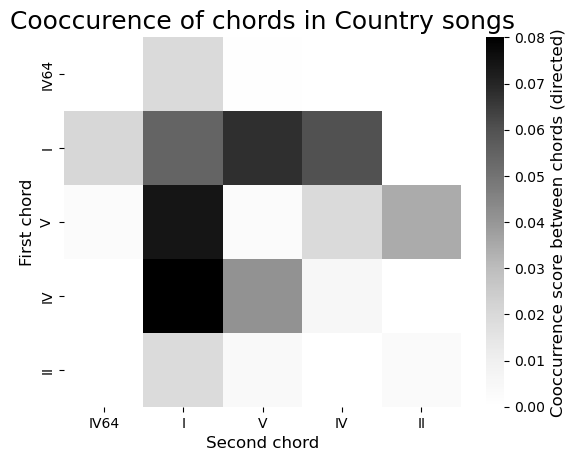

In [98]:
above_100_mask = (coocc['Country'] > 0.02).any()
country_100 = coocc['Country'][above_100_mask][list(above_100_mask[above_100_mask == True].index)]

ax = sns.heatmap(country_100, cmap='Greys', cbar_kws={'label': 'Cooccurrence score between chords (directed)'})
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.set_ylabel('First chord', fontsize=12)
ax.set_xlabel('Second chord', fontsize=12)
_ = ax.set_title('Cooccurence of chords in Country songs', fontsize=18)

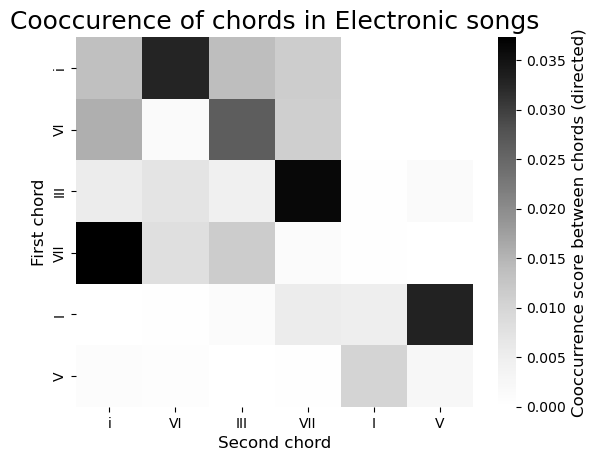

In [99]:
above_100_mask = (coocc['Electronic'] > 0.02).any()
electronic_100 = coocc['Electronic'][above_100_mask][list(above_100_mask[above_100_mask == True].index)]

ax = sns.heatmap(electronic_100, cmap='Greys', cbar_kws={'label': 'Cooccurrence score between chords (directed)'})
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.set_ylabel('First chord', fontsize=12)
ax.set_xlabel('Second chord', fontsize=12)
_ = ax.set_title('Cooccurence of chords in Electronic songs', fontsize=18)

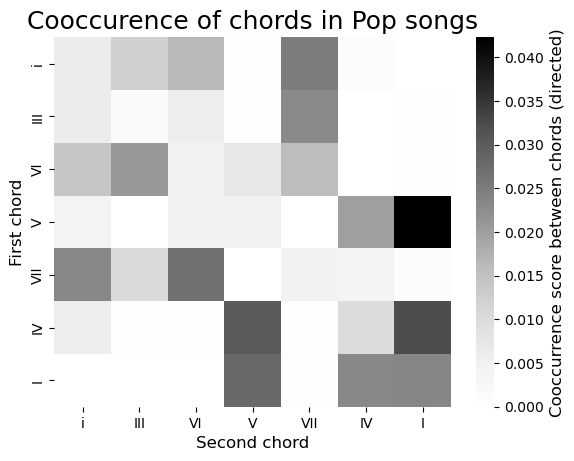

In [100]:
above_100_mask = (coocc['Pop'] > 0.02).any()
pop_100 = coocc['Pop'][above_100_mask][list(above_100_mask[above_100_mask == True].index)]

ax = sns.heatmap(pop_100, cmap='Greys', cbar_kws={'label': 'Cooccurrence score between chords (directed)'})
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.set_ylabel('First chord', fontsize=12)
ax.set_xlabel('Second chord', fontsize=12)
_ = ax.set_title('Cooccurence of chords in Pop songs', fontsize=18)

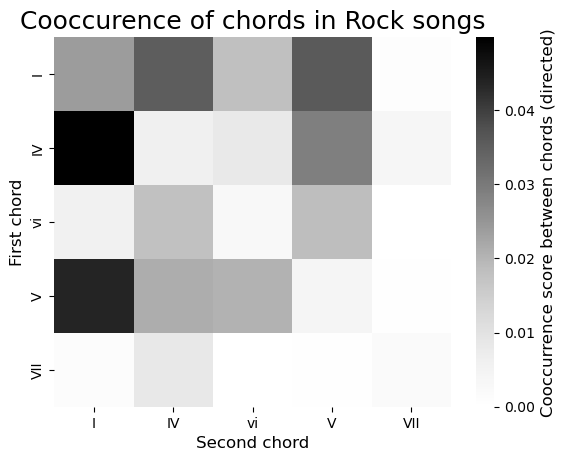

In [101]:
above_100_mask = (coocc['Rock'] > 0.02).any()
rock_100 = coocc['Rock'][above_100_mask][list(above_100_mask[above_100_mask == True].index)]

ax = sns.heatmap(rock_100, cmap='Greys', cbar_kws={'label': 'Cooccurrence score between chords (directed)'})
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.set_ylabel('First chord', fontsize=12)
ax.set_xlabel('Second chord', fontsize=12)
_ = ax.set_title('Cooccurence of chords in Rock songs', fontsize=18)

### Save nodelists and edgelists

In [102]:
for genre, df in dataframes.items():
    df.to_csv('../results/edge_lists/edges_' + genre.lower() + '.csv', index=False)
    nodelists[genre].to_csv('../results/node_lists/nodes_' + genre.lower() + '.csv', index=False)

In [103]:
dataframes['Rock']

,Source,Target,sum_appearance,percent,log_ratio,probability
0,I,I,514,0.024046,-0.139830,0.145857
1,I,I64,16,0.000749,1.021095,0.004540
2,I,I7,19,0.000889,0.378845,0.005392
3,I,I9,4,0.000187,1.803854,0.001135
4,I,II,75,0.003509,0.095476,0.021283
...,...,...,...,...,...,...
915,♯vi7,VII,1,0.000047,2.866089,1.000000
916,♯vi°,♯iii,1,0.000047,6.406243,1.000000
917,♯v°,I,1,0.000047,-0.393370,0.111111
918,♯v°,v7,1,0.000047,4.296030,0.111111


In [104]:
nodelists['Country']

,Id,sum_appearance,percent,average_appearance
0,IV64,62,0.023592,2.066667
1,I,736,0.280061,24.533333
2,vi,101,0.038432,3.366667
3,V,442,0.168189,14.733333
4,ii,116,0.044140,3.866667
5,IV,423,0.160959,14.100000
6,♭VII,39,0.014840,1.300000
7,I6,11,0.004186,0.366667
8,V7,15,0.005708,0.500000
9,I7,8,0.003044,0.266667


# Smol EDA

In [105]:
enmax_palette = ["#e36b64", '#84b4e4']
sns.set_palette(palette=enmax_palette)

In [106]:
eda_dict = {}
for genre in number_of_songs.keys():
    eda_dict[genre] = [modes[genre].count('major'), modes[genre].count('minor')]

In [107]:
df_eda = pd.DataFrame(eda_dict).transpose()
df_eda.columns = ['major', 'minor']
df_eda

,major,minor
Country,25,5
Electronic,21,22
Pop,70,27
Rock,144,68


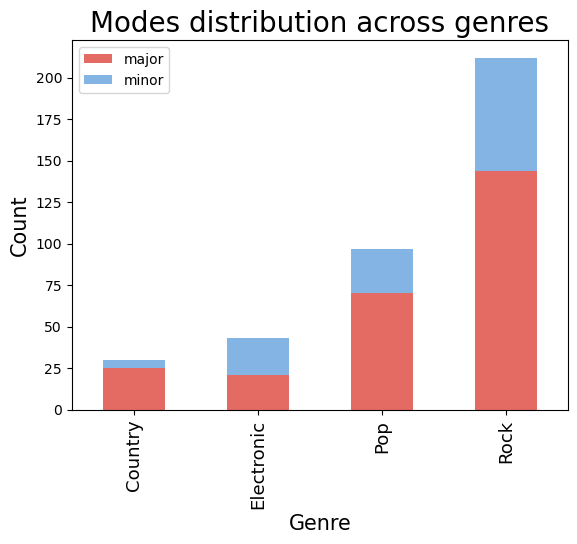

In [108]:
ax = df_eda.plot(kind='bar', stacked=True, color=['C0', 'C1'])
ax.set_xlabel('Genre', fontsize=15)
ax.set_xticks(range(0,len(df_eda.index)), df_eda.index, fontsize=13)
ax.set_ylabel('Count', fontsize=15)
_ = ax.set_title('Modes distribution across genres', fontsize=20)

## Distribution of Chord Progressions

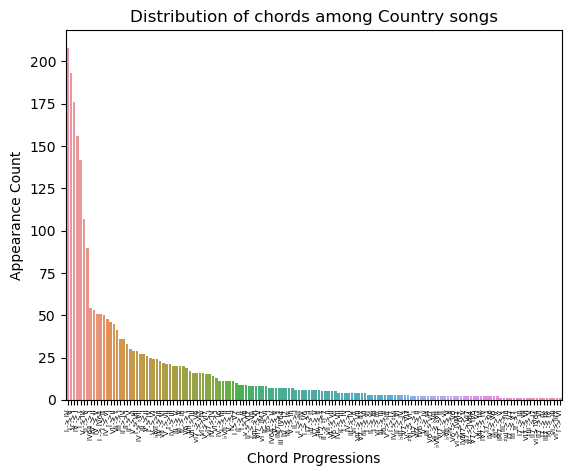

In [109]:
genre = 'Country'

df_plot = pd.DataFrame({'label': dataframes[genre]['Target'] + ' -> ' + dataframes[genre]['Source'], 'sum_appearance': dataframes[genre]['sum_appearance']}).sort_values('sum_appearance', ascending=False)
ax = sns.barplot(df_plot, x='label', y='sum_appearance')
ax.set_title('Distribution of chords among ' + genre + ' songs')
ax.set_xlabel('Chord Progressions')
ax.set_ylabel('Appearance Count')
_ = ax.set_xticklabels(rotation = 90, labels = df_plot.label, fontsize=5)

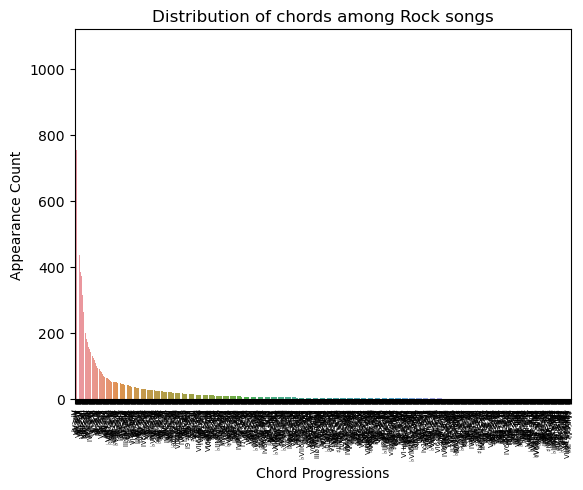

In [110]:
genre = 'Rock'

df_plot = pd.DataFrame({'label': dataframes[genre]['Target'] + ' -> ' + dataframes[genre]['Source'], 'sum_appearance': dataframes[genre]['sum_appearance']}).sort_values('sum_appearance', ascending=False)
ax = sns.barplot(df_plot, x='label', y='sum_appearance')
ax.set_title('Distribution of chords among ' + genre + ' songs')
ax.set_xlabel('Chord Progressions')
ax.set_ylabel('Appearance Count')
_ = ax.set_xticklabels(rotation = 90, labels = df_plot.label, fontsize=5)

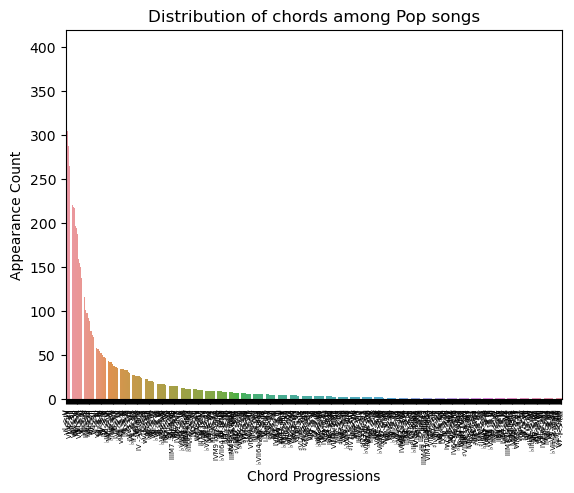

In [111]:
genre = 'Pop'

df_plot = pd.DataFrame({'label': dataframes[genre]['Target'] + ' -> ' + dataframes[genre]['Source'], 'sum_appearance': dataframes[genre]['sum_appearance']}).sort_values('sum_appearance', ascending=False)
ax = sns.barplot(df_plot, x='label', y='sum_appearance')
ax.set_title('Distribution of chords among ' + genre + ' songs')
ax.set_xlabel('Chord Progressions')
ax.set_ylabel('Appearance Count')
_ = ax.set_xticklabels(rotation = 90, labels = df_plot.label, fontsize=5)

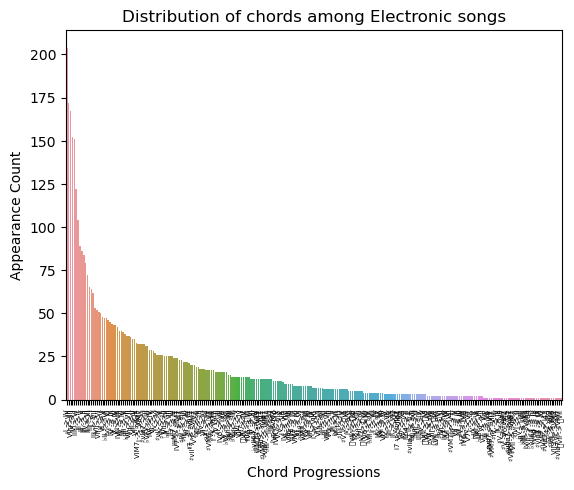

In [112]:
genre = 'Electronic'

df_plot = pd.DataFrame({'label': dataframes[genre]['Target'] + ' -> ' + dataframes[genre]['Source'], 'sum_appearance': dataframes[genre]['sum_appearance']}).sort_values('sum_appearance', ascending=False)
ax = sns.barplot(df_plot, x='label', y='sum_appearance')
ax.set_title('Distribution of chords among ' + genre + ' songs')
ax.set_xlabel('Chord Progressions')
ax.set_ylabel('Appearance Count')
_ = ax.set_xticklabels(rotation = 90, labels = df_plot.label, fontsize=5)